# PROJETO DE ANÁLISE: EXPORTAÇÕES
# Predição de Faturamento e Classificação de Pedidos

In [30]:
file = "2A - Base de Dados - Exportações.xlsx"
df = pd.read_excel(file, sheet_name="Registros de Vendas")
print("Dimensão inicial:", df.shape)  # (2891, 11)


Dimensão inicial: (2891, 11)


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [2]:
# ---- 2. CARREGAR OS DADOS ----
df = pd.read_excel("2A - Base de Dados - Exportações.xlsx")

print("Formato inicial:", df.shape)
print(df.head())



Formato inicial: (2891, 11)
   Unnamed: 0  ID_Pedido Data_Pedido  ID_Representante Nome_Representante  \
0         NaN  #P1000001  2024-01-01              1004   Isabela Carolina   
1         NaN  #P1000002  2024-01-01              1004   Isabela Carolina   
2         NaN  #P1000003  2024-01-01              1004   Isabela Carolina   
3         NaN  #P1000004  2024-01-01              1004   Isabela Carolina   
4         NaN  #P1000005  2024-01-01              1004   Isabela Carolina   

  ID_Produto    Nome_Produto     Categoria  Quantidade_Vendida  \
0    SKU9005   Celular Mod 3     Celulares                  32   
1    SKU9005   Celular Mod 3     Celulares                  25   
2    SKU9011  Notebook Mod 3  Computadores                  40   
3    SKU9004   Celular Mod 2     Celulares                  41   
4    SKU9011  Notebook Mod 3  Computadores                  38   

   Preço_Unitário                       Localidade  
0            1800                  Alemanha/Europa  
1     

In [25]:
# Conferir nomes das colunas
print("Colunas disponíveis:", df.columns.tolist())

# Verificar valores nulos antes de dropar
print("\nValores nulos por coluna:")
print(df[["Quantidade_Vendida", "Preço_Unitário", "Faturamento"]].isna().sum())

# Garantir que faturamento é numérico
df["Faturamento"] = pd.to_numeric(df["Faturamento"], errors="coerce")

# Verificar quantas linhas sobram depois da limpeza
df = df.dropna(subset=["Quantidade_Vendida", "Preço_Unitário", "Faturamento"])
print("\nDimensão após remoção de nulos:", df.shape)


Colunas disponíveis: ['ID_Representante', 'Nome_Representante', 'ID_Produto', 'Nome_Produto', 'Categoria', 'Quantidade_Vendida', 'Preço_Unitário', 'Localidade', 'Faturamento', 'Pedido_Alto']

Valores nulos por coluna:
Quantidade_Vendida    0
Preço_Unitário        0
Faturamento           0
dtype: int64

Dimensão após remoção de nulos: (0, 10)


In [32]:
# -------------------------
# 3. PREPARAÇÃO DOS DADOS (robusto a nomes diferentes)
# -------------------------

# Padronizar nomes das colunas para evitar problemas
df.columns = (
    df.columns
    .str.strip()
    .str.replace(" ", "_")
    .str.replace("ç", "c")
    .str.replace("ã", "a")
    .str.replace("é", "e")
    .str.replace("í", "i")
    .str.replace("ú", "u")
    .str.replace("ó", "o")
    .str.replace("á", "a")
)

print("Colunas após padronização:", df.columns.tolist())

# Detectar automaticamente as colunas de preço e quantidade
col_preco = [c for c in df.columns if "preco" in c.lower()][0]
col_qtd = [c for c in df.columns if "quantidade" in c.lower()][0]

print(f"➡️ Usando '{col_qtd}' como coluna de quantidade")
print(f"➡️ Usando '{col_preco}' como coluna de preço unitário")

# Criar Faturamento
df["Faturamento"] = df[col_qtd] * df[col_preco]

# Criar variável alvo para classificação (20% maiores pedidos)
threshold = df["Faturamento"].quantile(0.8)
df["Pedido_Alto"] = (df["Faturamento"] >= threshold).astype(int)

# Remover colunas irrelevantes se existirem
df = df.drop(columns=["Unnamed:_0", "ID_Pedido", "Data_Pedido"], errors="ignore")

# Conferir se há valores nulos
print("\nValores nulos por coluna:")
print(df[[col_qtd, col_preco, "Faturamento"]].isna().sum())

# Dropar apenas se houver nulos nas colunas críticas
df = df.dropna(subset=[col_qtd, col_preco, "Faturamento"])

# Codificação de variáveis categóricas
from sklearn.preprocessing import LabelEncoder, StandardScaler
label_encoders = {}
for col in df.select_dtypes(include=["object"]).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Normalizar variáveis numéricas (exceto target)
num_cols = df.select_dtypes(include=["int64", "float64"]).columns.drop("Faturamento", errors="ignore")

if len(df) > 0 and len(num_cols) > 0:
    scaler = StandardScaler()
    df[num_cols] = scaler.fit_transform(df[num_cols])
else:
    print("⚠️ Nenhum dado disponível para normalização.")

print("\n📊 Colunas finais:", df.columns.tolist())
print("📊 Amostras disponíveis:", len(df))
print("📊 Exemplo de dados:")
print(df.head())


Colunas após padronização: ['ID_Representante', 'Nome_Representante', 'ID_Produto', 'Nome_Produto', 'Categoria', 'Quantidade_Vendida', 'Preco_Unitario', 'Localidade', 'Faturamento', 'Pedido_Alto']
➡️ Usando 'Quantidade_Vendida' como coluna de quantidade
➡️ Usando 'Preco_Unitario' como coluna de preço unitário

Valores nulos por coluna:
Quantidade_Vendida    0
Preco_Unitario        0
Faturamento           0
dtype: int64

📊 Colunas finais: ['ID_Representante', 'Nome_Representante', 'ID_Produto', 'Nome_Produto', 'Categoria', 'Quantidade_Vendida', 'Preco_Unitario', 'Localidade', 'Faturamento', 'Pedido_Alto']
📊 Amostras disponíveis: 2891
📊 Exemplo de dados:
   ID_Representante  Nome_Representante  ID_Produto  Nome_Produto  Categoria  \
0         -0.444827           -0.375157   -0.358580     -0.358580  -0.973711   
1         -0.444827           -0.375157   -0.358580     -0.358580  -0.973711   
2         -0.444827           -0.375157    1.379802      1.379802   1.026999   
3         -0.444827

In [35]:
# 4. PREDIÇÃO DE FATURAMENTO (REGRESSÃO)
# -------------------------
X = df.drop(columns=["Faturamento", "Pedido_Alto"])
y = df["Faturamento"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Regressão Linear
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Random Forest Regressor
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("\n=== Regressão Linear ===")
print("R²:", r2_score(y_test, y_pred_lr))
print("MAE:", mean_absolute_error(y_test, y_pred_lr))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))

print("\n=== Random Forest Regressor ===")
print("R²:", r2_score(y_test, y_pred_rf))
print("MAE:", mean_absolute_error(y_test, y_pred_rf))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))



=== Regressão Linear ===
R²: 0.007927841682816683
MAE: 0.6773313856788157
RMSE: 1.1133686380638104

=== Random Forest Regressor ===
R²: 0.9613000681700301
MAE: 0.029261584019954674
RMSE: 0.21989859416246063


Amostras disponíveis para classificação: 2891

--- Classificação de Pedidos ---

Modelo: Logistic Regression
Accuracy: 0.613126079447323
Precision: 0.5913621262458472
Recall: 0.6379928315412187
F1 Score: 0.6137931034482759

--- Classificação de Pedidos ---

Modelo: Logistic Regression
Accuracy: 0.613126079447323
Precision: 0.5913621262458472
Recall: 0.6379928315412187
F1 Score: 0.6137931034482759


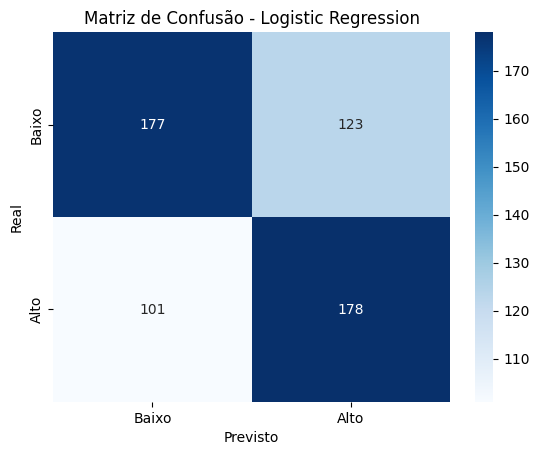


Modelo: Random Forest
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


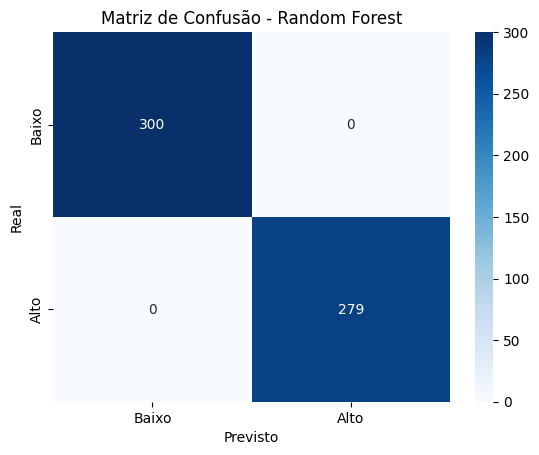

In [36]:
# ---- 5. CLASSIFICAÇÃO DE PEDIDOS (ALTO vs. BAIXO) ----
# Criar uma variável binária (1 = alto faturamento, 0 = baixo)
limite = df[target_reg].median()
df["Pedido_Alto"] = (df[target_reg] > limite).astype(int)

X_clf = df.drop(columns=[target_reg, "Pedido_Alto"])
y_clf = df["Pedido_Alto"]

print(f"Amostras disponíveis para classificação: {len(X_clf)}")
if len(X_clf) == 0:
    print("DataFrame vazio após o pré-processamento. Diagnóstico:")
    print("Primeiras linhas do DataFrame:")
    print(df.head())
    print("\nValores nulos por coluna:")
    print(df.isnull().sum())
    print("\nTipos das colunas:")
    print(df.dtypes)
    print("\nResumo estatístico:")
    print(df.describe(include='all'))
    import sys; sys.exit()  # Interrompe a execução para análise manual

X_train, X_test, y_train, y_test = train_test_split(X_clf, y_clf, test_size=0.2, random_state=42)

# Modelos
log_reg = LogisticRegression(max_iter=1000)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

log_reg.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)

# Predições
y_pred_log = log_reg.predict(X_test)
y_pred_rf_clf = rf_clf.predict(X_test)

# Métricas
print("\n--- Classificação de Pedidos ---")
for model_name, y_pred in [("Logistic Regression", y_pred_log), ("Random Forest", y_pred_rf_clf)]:
    print(f"\nModelo: {model_name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))

    # Matriz de confusão
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Baixo", "Alto"], yticklabels=["Baixo", "Alto"])
    plt.title(f"Matriz de Confusão - {model_name}")
    plt.xlabel("Previsto")
    plt.ylabel("Real")
    plt.show()